In [1]:
from helpers_given import load_csv_data
from preprocess import *
from helpers import *

Load data with helpers_given

In [2]:
x_train, x_test, y_train, train_ids, test_ids = load_csv_data("dataset/dataset_to_release", sub_sample=False)

y_train loaded
x_train loaded
x_test loaded


In [3]:
nb_col = x_train.shape[1]
nb_rows = x_train.shape[0]
print(nb_col)
print(nb_rows)

321
328135


Take care of the NaNs

Text(0.5, 1.0, 'Number of NaNs per feature before')

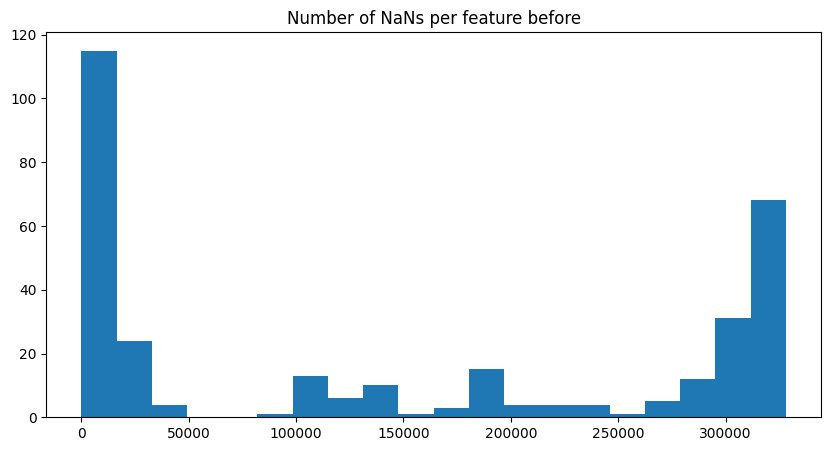

In [6]:
nb_nans = np.zeros(nb_col)
for i, col in enumerate(x_train.T):
    nb_nans[i] = np.count_nonzero(np.isnan(col))
plt.figure(figsize=(10, 5))
plt.hist(nb_nans, bins=20)
plt.title("Number of NaNs per feature before")


Text(0.5, 1.0, 'Number of NaNs per feature after')

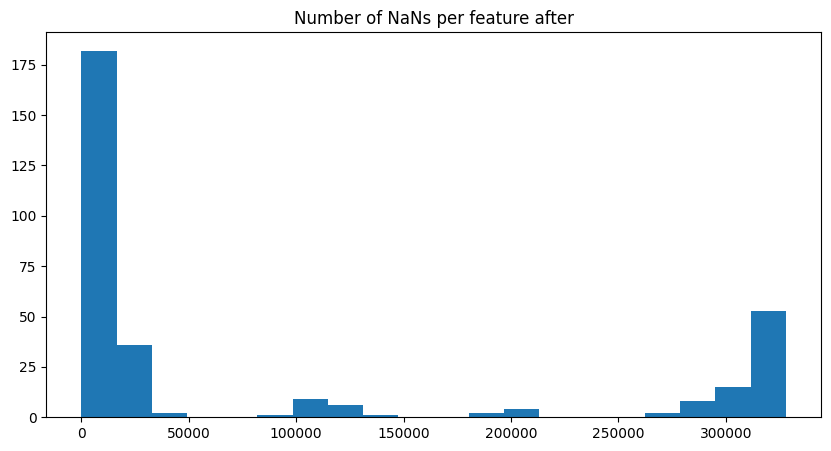

In [7]:
reduced_x_train, reduced_ids = removing_features(nb_nans, train_ids, x_train)

for i, col in enumerate(reduced_x_train.T):
    nb_nans[i] = np.count_nonzero(np.isnan(col))
plt.figure(figsize=(10, 5))
plt.hist(nb_nans, bins=20)
plt.title("Number of NaNs per feature after")

Standardize and remove nans

In [8]:
# remove the columns that have the same value in it (avoid std=0)
reduced_x_train, reduced_ids = remove_identic_col(reduced_ids, reduced_x_train)
nb_col_reduced = reduced_x_train.shape[1]
print(nb_col_reduced)

139


In [9]:
x_standardized = standardize_data(reduced_x_train)

clean_x_train = replace_NaN(x_standardized, method = 'mean')

## Run the methods a first time to see how we're doing

In [10]:
from implementations import *
NB_COL = clean_x_train.shape[1] # corresponds to 'D' = number of features
NB_ROWS = clean_x_train.shape[0] # corresponds to 'N' = number of observations/respondents

### Gradient descent

In [11]:
w_mse_gd, loss_mse_gd = mean_squared_error_gd(y_train, clean_x_train, initial_w = np.zeros(NB_COL), max_iters = 50, gamma = 0.001)

In [12]:
print(loss_mse_gd)
y_mse_gd = clean_x_train @ w_mse_gd
y_mse_gd = convert_predict(y_mse_gd)
print(y_mse_gd)

0.4912280486174677
[0. 1. 1. ... 1. 0. 0.]


In [ ]:
print(y_train)

### Subgradient descent

In [ ]:
w_mse_sgd, loss_mse_sgd = mean_squared_error_sgd(y_train, clean_x_train, initial_w = np.zeros(NB_COL), max_iters = 50, gamma = 0.001)
print(loss_mse_gd)
y_mse_gd = clean_x_train @ w_mse_gd
y_mse_gd = convert_predict(y_mse_gd)
print(y_mse_gd)

In [ ]:
w_ls, loss_ls = least_squares(y_train, x_train)
w_rr, loss_rr = ridge_regression(y_train, x_train, lambda_ = 0.5)
w_lrgd, loss_lrgd = logistic_regression(y_train, x_train, initial_w = np.zeros(NB_COL), max_iters = 50, gamma = 0.1, lambda_ = 0.5)
w_lrsgd, loss_lrsgd = logistic_regression_SGD(y_train, x_train, initial_w = np.zeros(NB_COL), max_iters = 50, gamma = 0.1, lambda_ = 0.5)
w_reg_lrgd, loss_reg_lrgd = reg_logistic_regression(y_train, x_train, initial_w = np.zeros(NB_COL), max_iters = 50, gamma = 0.1, lambda_ = 0.5)
w_reg_lrsgd, loss_reg_lrsgd = reg_logistic_regression_SGD(y_train, x_train, initial_w = np.zeros(NB_COL), max_iters = 50, gamma = 0.1, lambda_ = 0.5)

Idea to remove columns: compare means in population y=0 and y=1, and remove col for which those means are close
(this is done already a little with remove_identic_col for the columns that have the same value in each cell)

Cleaning outliers

In [ ]:
removed_outlier_x_train = clean_outliers(reduced_x_train)

In [ ]:
features_below_10_unique_values = {}
for i in range(reduced_x_train.shape[1]):
    # print(f"{reduced_features[i]}: {len(np.unique(reduced_data[:,i]))}")
    #print(f"{reduced_features[i]}: {np.unique(reduced_x_train[:,i])}")
    if len(np.unique(reduced_x_train[:,i])) < 10:
        features_below_10_unique_values[reduced_features[i]] = len(np.unique(reduced_x_train[:,i]))

# dealing with correlation 

def create_dictionary_from_correlation(correlation_threshold):
    newfeature_correlation_dict = {}
    # For each feature in the dataset calculate the correlation with the others and save those which have higher than 0.6 correlation
    for ft_num, feature in enumerate(reduced_features):
        newfeature_correlation_dict[feature] = []
        for o_ft_num, other_feature in enumerate(reduced_features):
            if (feature != other_feature):
                if np.abs(np.corrcoef(reduced_x_train[:,ft_num],reduced_x_train[:,o_ft_num])[0,1]) >= correlation_threshold:
                    newfeature_correlation_dict[feature].append(other_feature)
        print(f" Finished for feature: {feature}")
    return newfeature_correlation_dict

feature_correlation_dict = create_dictionary_from_correlation(0.6)
with open('feature_correlation_dict.pickle', 'wb') as handle:
    pickle.dump(feature_correlation_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('feature_correlation_dict.pickle', 'rb') as handle:
    feature_correlation_dict = pickle.load(handle)

### Run the functions on the data

In [ ]:
from implementations import *
w_mse_gd, loss_mse_gd = mean_squared_error_gd(y_train, x_train, initial_w = np.array([0,0]), max_iters = 50, gamma = 0.1)
w_mse_sgd, loss_mse_sgd = mean_squared_error_sgd(y_train, x_train, initial_w = np.array([0,0]), max_iters = 50, gamma = 0.1)
w_ls, loss_ls = least_squares(y_train, x_train)
w_rr, loss_rr = ridge_regression(y_train, x_train, lambda_ = 0.5)
w_lrgd, loss_lrgd = logistic_regression_GD(y_train, x_train, initial_w = np.array([0,0]), max_iters = 50, gamma = 0.1, lambda_ = 0.5)
w_lrsgd, loss_lrsgd = logistic_regression_SGD(y_train, x_train, initial_w = np.array([0,0]), max_iters = 50, gamma = 0.1, lambda_ = 0.5)
w_reg_lrgd, loss_reg_lrgd = regularized_logistic_regression_GD(y_train, x_train, initial_w = np.array([0,0]), max_iters = 50, gamma = 0.1, lambda_ = 0.5)
w_reg_lrsgd, loss_reg_lrsgd = regularized_logistic_regression_SGD(y_train, x_train, initial_w = np.array([0,0]), max_iters = 50, gamma = 0.1, lambda_ = 0.5)